In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langchain_community langchain_anthropic langchain_experimental faiss-cpu tiktoken pypdf langchain openai langchain_anthropic langchain_experimental


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importación de librerias
# LangGraph
from langgraph.graph import START, END, StateGraph
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent

# LangChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage

# Utilidades
from typing import TypedDict, Optional, Dict, List, Literal, Annotated
from dotenv import load_dotenv, find_dotenv
import tiktoken
from IPython.display import Image, display

In [3]:
# Carga de variables de entorno
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

True

In [4]:
def count_tokens_in_docs(docs, model_name="gpt-4o"):
    """
    Calcula la cantidad total de tokens para una lista de documentos
    usando la librería tiktoken.

    :param docs: Lista de documentos (por ejemplo, la salida de un loader PDF).
    :param model_name: Nombre del modelo para el que queremos simular el conteo.
    :return: Número total de tokens en el contenido de los documentos.
    """
    # Obtenemos la codificación que usa el modelo seleccionado
    encoding = tiktoken.encoding_for_model(model_name)

    total_tokens = 0
    for doc in docs:
        # doc.page_content es el texto de cada página/documento
        text = doc.page_content
        total_tokens += len(encoding.encode(text))

    return total_tokens

In [5]:
# 2. CARGA DEL PDF
# ----------------------------------------------------------------------------
file_path = "embeddings/manual_rrhh.pdf"
loader = PyPDFLoader(file_path)
docs = loader.load()

In [6]:
# Cantidad de documentos extraídos (páginas, secciones, etc. según PyPDFLoader)
print("Número de docs cargados:", len(docs))

# Opcional: vista previa de los primeros 100 caracteres de la primera página
print("Preview contenido:", docs[0].page_content[0:100])
print("Metadata:", docs[0].metadata)

Número de docs cargados: 1
Preview contenido: MANUAL DE RRHH - ICPACIFICO
1. VACACIONES
Todo trabajador tiene derecho a 15 días hábiles de vacacio
Metadata: {'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/', 'creator': 'PyPDF', 'creationdate': 'D:20250624201848', 'source': 'embeddings/manual_rrhh.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}


In [7]:
# 3. CONTAR TOKENS ANTES DE HACER NADA
# ----------------------------------------------------------------------------
tokens_en_documento = count_tokens_in_docs(docs, model_name="gpt-4o")
print("Tokens en el documento completo:", tokens_en_documento)

Tokens en el documento completo: 172


In [8]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
splits = text_splitter.split_documents(docs)

In [9]:
# Crea los embeddings
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(splits, embeddings)

# Crea el retriever
# retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
retriever = vectorstore.as_retriever(search_kwargs={"k": 10, "score_threshold": 0.3})

In [10]:
# Modelo utilizado
llm = ChatOpenAI(model="gpt-4o")

In [11]:
# Creación del estado
class GlobalState(TypedDict): # Estado Globa
    graph: str
    messages: list[dict] # Es una lista de diccionarios
    next: str

In [12]:
# Miembros del equipo
members = ["consultas", "amparo"]
# members = ["consultas"]
options = members + ["FINISH"]

In [13]:
# Router con opciones para el llm
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["consultas", "amparo", "FINISH"]
#     next: Literal["consultas", "FINISH"]


In [14]:
# Definir un nodo info o agent principal
system_prompt_amparo = "Eres Amparo una asistente virtual de recursos humanos creado para responder los saludos de nuestros trabajadores. Para responder a los saludos de los usuarios como, Hola, Buenas tardes, Necesito ayuda, responde con [Hola soy Amparo asistente virtual del Equipo de desarrollo Humano. ¿En que te puedo ayudar? o con algun mensale de saludo y presentación con esas caracteristicas. No respondas nada que esté fuera de este contexto."
info_agent = create_react_agent(
    llm,
    tools=[],
    prompt=ChatPromptTemplate.from_messages([
        ("system", system_prompt_amparo),
        ("human", "{messages}")
    ])
)

def amparo_node(state: GlobalState) -> Command[Literal["supervisor"]]:
#def amparo_node(state: GlobalState) -> Command[Literal["__end__"]]:
    result = info_agent.invoke(state)
    print("RESPUESTA DE Amparo: \n")
    print(result["messages"])
    return Command(
        goto="supervisor",
        update={"messages": result["messages"]}
    )

In [15]:
# Crea una herramienta a partir del retriever
retriever_tool = create_retriever_tool(
    retriever,
    name="info_retriever",
    description="Busca información en el pdf para responder a las preguntas de los trabajadores."
)

In [16]:
# Crea el agente con la herramienta
retriever_agent = create_react_agent(
    llm,
    tools=[retriever_tool],
    prompt="Eres un agente experto en responder preguntas sobre recursos humanos,"
)

In [17]:
def retriever_node(state: GlobalState) -> Command[Literal["__end__"]]:
    result = retriever_agent.invoke(state)
    return Command(
        goto="supervisor",
        update={
            "messages": result["messages"]
        }
    )

In [18]:
system_prompt = (
    "Tu nombre es Amparo, una agente virtual que apoya las gestiones del área de Recursos Humanos "
    "de la empresa Inmobiliaria Costanera Pacífico. Tu función principal es analizar las solicitudes de los trabajadores "
    f"y derivarlas a los siguientes agentes especializados: {members}.\n\n"

    "El agente especializado 'consultas' se encarga de responder preguntas sobre normativa interna, beneficios, reglamentos, "
    "y cualquier otro aspecto relacionado con Recursos Humanos, utilizando como fuente un documento PDF que contiene la información oficial.\n\n"

    "Tu tarea es analizar el mensaje del trabajador y decidir qué agente debe actuar en función de la solicitud.\n"
    "Si la solicitud es general o informal, selecciona el agente más apropiado para responder o investigar.\n"
    "Si ya se resolvió completamente, responde únicamente con 'FINISH'.\n\n"

    "Devuelve **únicamente** el nombre del agente a activar (por ejemplo: consultas), o 'FINISH' si todo ha concluido."
)


In [19]:
# def supervisor_node(state: GlobalState) -> Command[Literal["consultas","__end__"]]:
def supervisor_node(state: GlobalState) -> Command[Literal["consultas","amparo", "__end__"]]:
    print("Este es el mensaje que recibe el supervisor: \n")
    print(state["messages"])
    ultimo_ai = next((msg for msg in reversed(state["messages"]) if isinstance(msg, AIMessage)), None)
    print("ULTIMO AI: ", ultimo_ai)
    # if ultimo_ai:
    if isinstance(state["messages"][-1], AIMessage):
        # ultimo_ai= ultimo_ai.content
        # ultimo_ai= list(ultimo_ai)
        # messages = [{"role":"system", "content":system_prompt},] + ultimo_ai
        goto = "FINISH"
    else:
        messages = [{"role":"system", "content":system_prompt},] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
    print("DIRIGIENDO FLUJO A: ", goto)
    if goto == "FINISH":
        goto = END
    
    return Command(goto=goto, update = {"next":goto})

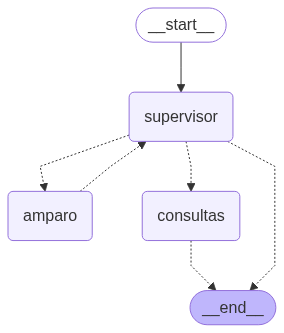

In [20]:
builder = StateGraph(GlobalState)
builder.add_edge(START, "supervisor")
builder.add_node("amparo", amparo_node)
builder.add_node("supervisor", supervisor_node)
builder.add_node("consultas",retriever_node)

graph =  builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
sal = graph.invoke({"messages": ["Hola, quisiera solicitar un certificado de antiguedad"]})
for m in sal["messages"]:
    m.pretty_print()

Este es el mensaje que recibe el supervisor: 

['Hola, quisiera solicitar un certificado de antiguedad']
ULTIMO AI:  None
DIRIGIENDO FLUJO A:  amparo
RESPUESTA DE Amparo: 

[HumanMessage(content='Hola, quisiera solicitar un certificado de antiguedad', additional_kwargs={}, response_metadata={}, id='0cff10c0-9230-4bb1-9e52-0495d9a852cf'), AIMessage(content='Hola soy Amparo, asistente virtual del Equipo de Desarrollo Humano. ¿En qué te puedo ayudar?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 151, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BzoU4A5uCvQO12i8Hn4UyfU0PK1Wt', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run